# LiteralEvaluation - Ablation Experiments: Tables and Plots

This notebook plots the results and creates the Latex tables for all ablation experiments. All tables and plots are saved in the `data/tex` directory.

This notebook uses the result logs from `NUM_RUNS` runs stored in `data/results/results_run_[run number]`. The result logs produced during all our experiments (over 3 runs) are included for completeness.

Settings and definition of constants (usually not required to adjust):

In [19]:
import os
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp

NUM_RUNS = 3
DATA_PATH = '../data'
RESULTS_PATH = osp.join(DATA_PATH, 'results') 
TEX_PATH = osp.join(DATA_PATH, 'tex')

COLOR_A = '#66c2a5'  # green (used for original features
COLOR_B = '#8da0cb'  # blue (used for random features)

model_2_name = json.load(open(osp.join(DATA_PATH, 'tex', 'constants.json'), 'r'))['model_2_name']


dataset_2_name = {
    'fb15k-237': 'FB15k-237',
    'yago3-10': 'YAGO3-10',
    'litwd48k': 'LitWD48k'
}

## Read Results

All results are read into a dictionary with the following structure:
`dataset` -> `model` -> `feature_type` -> `rel_abl`. The elements are lists 
of dictionaries containing the evaluation metrics for every run: `MRR`, `MR`, `Hits@10`, `Hits@3`, `Hits@1`

Attention: The results for some combinations of `model`, `feature_type`, and `rel_abl` might not be available. In these cases, the elements are empty lists.

###  Rename KGA Files
The file names are named differently for KGA than for the other models. This code renames the files to match the other models.

In [20]:
# Iterate over all runs of the experiment. 
for run_i in range(1, 4):
    directory = osp.join(RESULTS_PATH, f'results_run_{run_i}')
    
    # Iterate over all files of the respective run.
    for filename in os.listdir(directory):
        
        # Rank files do not need to be renamed.
        if 'ranks' in filename:
            continue
            
        # Rename the KGA result files to match the other models.
        pattern = r'_run-.*_QHC_5'
        if re.search(pattern, filename):
            new_filename = re.sub(pattern, '', filename)
            print('renamed', filename, 'to', new_filename)
            
            new_filename = new_filename.replace('rel-', '')
            new_filename = new_filename.replace('_sparse', '')
        
            old_file_path = osp.join(directory, filename)
            new_file_path = osp.join(directory, new_filename)
            os.rename(old_file_path, new_file_path)

print("Files have been renamed successfully.")

Files have been renamed successfully.


### Fill the dictionary with the results

In [21]:
def extract_test_scores(result_file_path):
    MRR = None
    MR = None
    Hits_at_10 = None
    Hits_at_3 = None
    Hits_at_1 = None

    with open(result_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'transea' in result_file_path.lower():
                if line.startswith('Test MR'):
                    MR, MRR, Hits_at_10, Hits_at_3, Hits_at_1 = [float(score.replace(': ', '')) for score in re.findall(": \d.\d.\d*", line)]

            else:
                if 'Mean reciprocal rank:' in line:
                    MRR = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Mean rank:' in line:
                    MR = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Hits @10:' in line:
                    Hits_at_10 = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Hits @3:' in line:
                    Hits_at_3 = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Hits @1:' in line:
                    Hits_at_1 = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))

    return {'MRR': MRR, 'MR': MR, 'Hits@10': Hits_at_10, 'Hits@3': Hits_at_3, 'Hits@1': Hits_at_1}

In [32]:
result_dict = {}
for dataset in dataset_2_name.keys():
    result_dict[dataset] = {}
    for model in model_2_name.keys():
        result_dict[dataset][model] = {}
        for feature_type in ['org', 'rand', 'attribute']:
            result_dict[dataset][model][feature_type] = {}
            for rel_abl in ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']:
                result_dict[dataset][model][feature_type][rel_abl] = []
                
                for run_i in range(1, NUM_RUNS + 1):
            
                    results_file_name = f'slurm_{model}_{dataset}_{feature_type}_{rel_abl}.txt'
                    
                    if osp.isfile(osp.join(RESULTS_PATH, f'results_run_{run_i}/{results_file_name}')): 
                        s = extract_test_scores(osp.join(RESULTS_PATH, f'results_run_{run_i}/{results_file_name}'))
                        #print(s)
                        result_dict[dataset][model][feature_type][rel_abl].append(s)
                        #print(f'Loaded: {osp.join(RESULTS_PATH, f"results_run_{run_i}/{results_file_name}")}')
                    else:
                        #print(f'File not found: {osp.join(RESULTS_PATH, f"results_run_{run_i}/{results_file_name}")}')       
                        pass

Save the results dictionary to a json file.

In [33]:
json.dump(result_dict, open(osp.join(RESULTS_PATH, 'results_dict.json'), 'w'), indent=4)

## Plots
### Original Literal Feature vs. Random Features 

The following code visualizes the results of the ablation experiments, comparing the performance of the original literal feature against random features.

The figure size can be adjusted using the fig_size variable, which accepts `'L'` for a large figure or `'S'` for a small figure. The small figure (*org_vs_rand_S.pdf*), which contains only the most relevant results, is intended for the main part of the paper. Conversely, the large figure (*org_vs_rand_L.pdf*), which includes results for all model and dataset combinations, is reserved for the appendix.

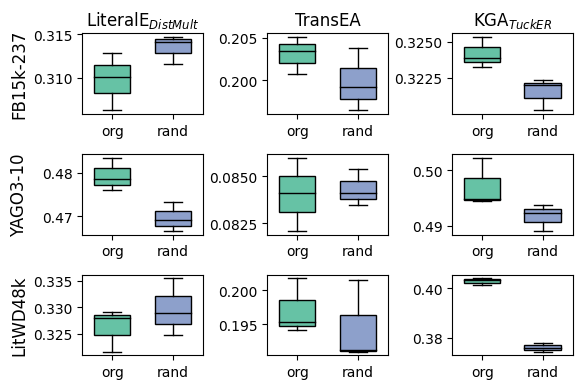

In [15]:
fig_size = 'S'  # 'L' for large, 'S' for small

if fig_size == 'L':
    datasets = ['fb15k-237', 'yago3-10', 'litwd48k']
    models = ['literaledistmult', 'literalecomplex', 'kbln', 'multitask', 'transea', 'kgatucker', 'kgadistmult']
    fig, axs = plt.subplots(len(datasets), len(models), figsize=(12, 7))
else: 
    datasets = ['fb15k-237', 'yago3-10', 'litwd48k']
    models = ['literaledistmult', 'transea', 'kgatucker']
    fig, axs = plt.subplots(len(datasets), len(models), figsize=(6, 4))

medianprops = dict(linestyle='-', linewidth=1, color='black')

for j, dataset in enumerate(datasets):
    for i, model in enumerate(models):
        for feature_type in ['org', 'rand']:
            try:
                MRR = [result['MRR'] for result in result_dict[dataset][model][feature_type]['0']]
                
            except Exception as e:
                print(e)
                MRR = [0.1]
                print(f'results file missing for: {model}, {dataset}, {feature_type}')
            #print(dataset, model, feature_type, np.mean(MRR), np.std(MRR))

            axs[j, i].boxplot(MRR, positions=[0 if feature_type == 'org' else 1], widths=0.6, showfliers=False, medianprops=medianprops, patch_artist=True, boxprops=dict(facecolor=COLOR_A) if feature_type == 'org' else dict(facecolor=COLOR_B))
            axs[j, i].set_xticks([0, 1])
            axs[j, i].set_xticklabels(['org', 'rand'])

for ax, col in zip(axs[0], [model_2_name[m] for m in models]):
    ax.set_title(col)

for ax, row in zip(axs[:,0], ['FB15k-237', 'YAGO3-10', 'LitWD48k']):
    ax.set_ylabel(row, rotation=90, size='large')
    if fig_size == 'L':
        ax.get_yaxis().set_label_coords(-0.8,0.5)
    else:
        ax.get_yaxis().set_label_coords(-0.45,0.5)

plt.tight_layout()
plt.savefig(osp.join(TEX_PATH, f'org_vs_rand_fig_{fig_size}.pdf'))
plt.show()

### Relation Ablation Figure

The following code visualizes the results of the relation ablation experiments, comparing the performance of the original literal feature against random features when reducing the available relational triples.

For the paper, we visualize the results for four models on the FB15k-237 dataset: LiteralE$_{DistMult}$ (*rel_abl_literaledistmult_fig.pdf*), MTKGNN (*rel_abl_multitask_fig.pdf*), KGA$_{TuckER}$ (*rel_abl_kgatucker_fig.pdf*), and KGA$_{DistMult}$ (*rel_abl_kgadistmult_fig.pdf*).



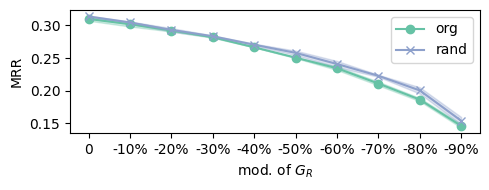

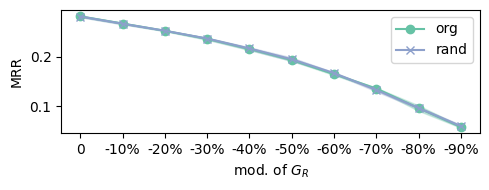

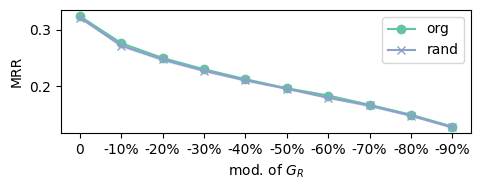

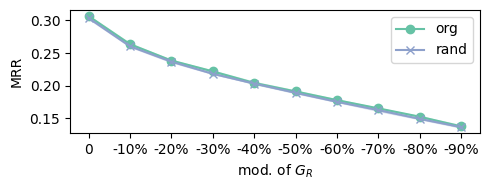

In [17]:
def vis_rel_feature_abl(model_name):
 
    x = ['0', '-10%', '-20%', '-30%', '-40%', '-50%', '-60%', '-70%', '-80%', '-90%']

    def get_mean_std_ablation(model='kgatucker', t='org', dataset='fb15k-237'):
        mrr = []
        for i in range(0,3):    
            mrr += [[result_dict[dataset][model][t][percent][i]['MRR'] for percent in ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']]]

        mrr = np.array(mrr)
        mrr = np.array([[x if x is not None else np.nan for x in row] for row in mrr])  # replace None with nan

        mean = np.nanmean(np.array(mrr), axis=0)
        std = np.std(mrr, axis=0)
        return mean, std


    mrr_mean_org, mrr_std_org = get_mean_std_ablation(model=model_name, t='org', dataset='fb15k-237')
    mrr_mean_rand, mrr_std_rand = get_mean_std_ablation(model=model_name, t='rand', dataset='fb15k-237')

    plt.figure(figsize=(5,2))
    plt.plot(x, mrr_mean_org, '-o', color=COLOR_A)
    plt.plot(x, mrr_mean_rand, '-x', color=COLOR_B)

    plt.fill_between(x, mrr_mean_org-mrr_std_org, mrr_mean_org+mrr_std_org, alpha=0.3, color=COLOR_A)
    plt.fill_between(x, mrr_mean_rand-mrr_std_rand, mrr_mean_rand+mrr_std_rand, alpha=0.3, color=COLOR_B)

    plt.ylabel('MRR')
    plt.xlabel('mod. of $G_R$')

    plt.legend(['org', 'rand'])

    plt.tight_layout()
    plt.savefig(osp.join(TEX_PATH, f'rel_abl_{model_name}_fig.pdf'))
    plt.show()

vis_rel_feature_abl('literaledistmult')
vis_rel_feature_abl('multitask')
vis_rel_feature_abl('kgatucker')
vis_rel_feature_abl('kgadistmult')

## Tables

### Original Literal Feature vs. Random Features 

The following code creates a Latex table (*org_vs_rand_tab.tex*) comparing the performance of models trained on the original literal feature versus those trained on random features.

In [41]:
out_file = open(osp.join(TEX_PATH, 'org_vs_rand_tab.tex'), 'w')

head = """
\\begin{table*}[]
\setlength{\\tabcolsep}{6pt}
\\renewcommand{\\arraystretch}{1.1}

\caption{Comparison of scores of models trained on the datasets provided with the original literal feature versus those trained on datasets provided with random features.}
\\label{tab:org_vs_rand}
\\begin{center}
\\begin{tabular}{l|rll|rll}

\hline
      & \multicolumn{3}{c|}{\\textbf{Original features}} & \multicolumn{3}{c}{\\textbf{Random features}} \\\\
\\textbf{Model}      & \\textbf{MR} & \\textbf{MRR} & \\textbf{Hits@1} & \\textbf{MR}  & \\textbf{MRR} & \\textbf{Hits@1} \\\\ \hline
"""

tail = """
\hline
\end{tabular}
\end{center}
\end{table*}
"""

out_file.write(head + '\n')

for dataset in dataset_2_name.keys():
    out_file.write(f'\hline \multicolumn{{7}}{{c}}{{\\textbf{{{dataset_2_name[dataset]}}}}} \\\\ \\hline \n')
    for model in model_2_name.keys():
        line_string = model_2_name[model]
        for feature_type in ['org', 'rand']:      

            for metric in ['MR', 'MRR', 'Hits@1']:
                try:
                    scores = [result[metric] for result in result_dict[dataset][model][feature_type]['0']]
                    if metric == 'MR':
                        mean = f'{np.mean(scores):.0f}'
                        std = f'{np.std(scores):.0f}'.zfill(3)
                    else:
                        mean = f'{np.mean(scores):.3f}'[1:]
                        std = f'{np.std(scores):.3f}'[1:]
                    line_string += f'& ${mean}{{\scriptstyle \pm {std}}}$ '
                except:
                    line_string += '& - '
        out_file.write(line_string + ' \\\\ \n')

out_file.write(tail)
out_file.close()

### Attribute Literal Features (vs. Original Features vs. Random Features)

The following code creates a Latex table (*variations_tab.tex*) comparing the performance when only the type of the attributive relation is provided to the models (not the actual literal value) against the original literal feature and random features.



In [53]:
out_file = open(osp.join(TEX_PATH, 'variations_tab.tex'), 'w')

head = """
\\begin{table*}[]
\setlength{\\tabcolsep}{6pt}
\\renewcommand{\\arraystretch}{1.1}

\caption{Comparison of models trained and evaluated on datasets, each subjected to all proposed literal ablations. The model that uses the literals provided with the dataset is named \\textit{original}. The models that use only the relation type and not the concrete literal value are are named \\textit{relation type}. }
\\label{tab:variations}
\\begin{center}

\\begin{tabular}{l|l||lllll}
\hline
& \multicolumn{1}{l||}{\\textbf{features}} & \\textbf{MR} & \\textbf{MRR} & \\textbf{Hits@1} & \\textbf{Hits@3} & \\textbf{Hits@10} \\\\
"""


tail = """
\hline
\end{tabular}
\end{center}
\end{table*}
"""

feature_variante_2_label = {
    'org': 'original',
    'rand': 'random',
    'attribute': 'relation type',
    'base-model': 'base model'
}

out_file.write(head)


for dataset in ["fb15k-237", "yago3-10", "litwd48k"]:
    out_file.write(f'\hline \multirow{{8}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{dataset_2_name[dataset]}}}}} \n')


    for model_idx, model in enumerate(['kgatucker', 'kgadistmult']):
        if model_idx != 0:
            out_file.write('\cline{2-7} \n')
        
        out_file.write(f'& \multicolumn{{6}}{{c}}{{\\textbf{{{model_2_name[model]}}}}} \\\\ \n \cline{{2-7}} \n')
        
        for feature_variante in ['org', 'rand', 'attribute']:
            line_string = f'& {feature_variante_2_label[feature_variante]} '
    
            for metric in ['MR', 'MRR', 'Hits@1', 'Hits@3', 'Hits@10']:
                try:
                    scores = [result[metric] for result in result_dict[dataset][model][feature_variante]['0']]
                    
                    if metric == 'MR':
                        mean = f'{np.mean(scores):.0f}'
                        std = f'{np.std(scores):.0f}'.zfill(3)
                    else:
                        mean = f'{np.mean(scores):.3f}'[1:]
                        std = f'{np.std(scores):.3f}'[1:]
                    line_string += f'& ${mean}{{\scriptstyle \pm {std}}}$ '
                except:
                    line_string += '& - '    
                
            out_file.write(line_string + '\\\\ \n')

out_file.write(tail)
out_file.close()

### Dataset statistics

Entities without numerical literals

In [22]:
for dataset in ['FB15k-237', 'YAGO3-10', 'LitWD48K', 'Synthetic']:
    entities_relational_triples = set()
    for split in ['train', 'valid', 'test']:
        with open(osp.join(DATA_PATH, f'{dataset.lower()}/{split}.txt'), 'r') as f:
            lines = f.readlines()

            for line in lines:
                head, rel, tail = line.strip().split('\t')
                entities_relational_triples.add(head)
                entities_relational_triples.add(tail)

    entities_attributive_triples = set()
    m = '_decimal' if dataset == 'LitWD48K' else ''
    with open(osp.join(DATA_PATH, f'{dataset}/literals/numerical_literals{m}.txt'), 'r') as f:
        lines = f.readlines()
        for line in lines:
            entity, attr, value = line.strip().split('\t')
            entities_attributive_triples.add(entity)
    print(dataset, ':', len(entities_relational_triples) - len(entities_attributive_triples))


FB15k-237 : 4600
YAGO3-10 : 31030
LitWD48K : 8198
Synthetic : 38
